# Apakah Font Lama dan Baru Memberi Perbedaan Signifikan?

- Pendahuluan
- Tahap 1. Pra-pemrosesan Data
- Tahap 2. Analisa Data
- Tahap 3. Mempelajari Event Funnel
    - Membuat Pivot Table
    - Rasio Pengguna
- Tahap 4. Mempelajari Hasil Eksperimen
    - Menghitung Jumlah Pengguna Setiap Event
    - Event Terpopuler
    - Melakukan A/A Testing
    - Melakukan A/B Testing
    - Melakukan A/A/B Testing
    - Menguji Dengan Tingkat Alpha Berbeda
- Tahap 5. Kesimpulan

# Pendahuluan
Bekerja di sebuah start-up yang bergerak dalam bidang penjualan produk makanan, sebagai seorang analis, kita perlu menganalisa perilaku pengguna aplikasi dari waktu ke waktu. 

Para web designer ingin mengubah seluruh font menjadi font baru, namun para manajer khawatir bahwa font baru akan membuat pengguna merasa kurang nyaman dengan tampilannya. Maka dari itu mereka memutuskan untuk mengambil keputusan berdasarkan A/A/B Testing.

Para pengguna dibagi menjadi 2 kelompok kontrol aplikasi dengan font lama, dan  1 kelompok uji aplikasi dengan font baru. 2 kelompok kontrol ini perlu kita uji terlebih dahulu apakah proporsinya setara dan kemudian baru kita test dengan kelommpok uji.

Untuk melakukan testing, kita akan menganalisa corong peristiwa dan penggunanya lebih dulu.

## Tahap 1. Pra-pemrosesan Data
Sebelum memulai analisa apapun, kita perlu memuat library data yang dibutuhkan.

### Memuat Library

In [1]:
# memuat library yang dibutuhkan
import pandas as pd
import numpy as np
from scipy import stats
import math
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Memuat Data

In [2]:
# memuat data
df = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

Dataset ini memiliki kolom sebagai berikut :
- `EventName` — nama event
- `DeviceIDHash` - id unik pengguna
- `EventTimestamp` — waktu event
- `ExpId` — jumlah eksperimen : 246 dan 247 adalah grup kontrol, 218 adalah grup uji

In [3]:
# menampilkan data
df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [4]:
# menampilkan informasi umum
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Mengubah Nama Kolom
Agar lebih mudah dan nyaman dibaca, kita akan mengubah nama kolom menjadi lebih sederhana dan rapi.

In [5]:
# mengubah nama kolom
df = df.rename(columns={
    'EventName' : 'event',
    'DeviceIDHash' : 'user_id',
    'EventTimestamp' : 'event_ts',
    'ExpId' : 'exp_number'
})

### Mengubah Tipe Data
Ada beberapa kolom yang memiliki tipe data tidak sesuai dengan valuenya.

In [6]:
# mengubah tipe data pada kolom
df['event_new_ts'] = pd.to_datetime(df['event_ts'], unit='s')

In [7]:
# membuat kolom baru untuk tanggal
df['event_date'] = pd.to_datetime(df['event_new_ts'].dt.date)

In [8]:
# mengecek semua nama pada kolom event name
df['event'].value_counts()

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: event, dtype: int64

In [9]:
# mengubah penulisan pada value kolom event name
df['event'] = df['event'].replace({'MainScreenAppear' : 'Main Screen Appear',
                                            'OffersScreenAppear' : 'Offers Screen Appear',
                                            'CartScreenAppear' : 'Cart Screen Appear',
                                            'PaymentScreenSuccessful' : 'Payment Screen Successful'})

In [10]:
# menampilkan data terbaru
df

,event,user_id,event_ts,exp_number,event_new_ts,event_date
0,Main Screen Appear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,Main Screen Appear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,Payment Screen Successful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,Cart Screen Appear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,Payment Screen Successful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,Main Screen Appear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,Main Screen Appear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,Main Screen Appear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,Main Screen Appear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


### Mengecek Nilai Duplikat dan Missing Value

In [11]:
# mengecek nilai duplikat
df.duplicated().sum()

413

In [12]:
# menghapus duplikat
df = df.drop_duplicates()

In [13]:
# mengecek nilai duplikat
df.duplicated().sum()

0

In [14]:
# mengecek missing value
df.isnull().sum()

event           0
user_id         0
event_ts        0
exp_number      0
event_new_ts    0
event_date      0
dtype: int64

## Tahap 2. Analisis Data
Kita akan melihat berapa banyak event yang ada dalam log

### Jumlah Event

In [15]:
# jumlah masing-masing event dalam log
df['event'].value_counts()

Main Screen Appear           119101
Offers Screen Appear          46808
Cart Screen Appear            42668
Payment Screen Successful     34118
Tutorial                       1018
Name: event, dtype: int64

Ada 5 macam event, jumlah terbanyak event adalah main screen. Sedangkan jumlah event tutorial memiliki jumlah yang sangat sedikit jika dibandingkan dengan event lainnya.
Berikutnya kita akan melihat jumlah pengguna yang ada pada setiap event.

### Jumlah Pengguna Setiap Event

In [16]:
# jumlah pengguna pada setiap log
df.groupby('event').agg({'user_id':'nunique'})

,user_id
event,
Cart Screen Appear,3749
Main Screen Appear,7439
Offers Screen Appear,4613
Payment Screen Successful,3547
Tutorial,847


### Memfilter Data Lama dan Baru
Kita perlu menggunakan data akurat untuk menjalankan test ini. Terdapat kemungkinan bahwa ada outlier atau data yang dianggap sebagai "data lama" yang dapat membuat hasil test menjadi keliru.

In [17]:
# melihat tanggal minimal dan maksimum event
print(df['event_date'].min())
print(df['event_date'].max())

2019-07-25 00:00:00
2019-08-07 00:00:00


<AxesSubplot:>

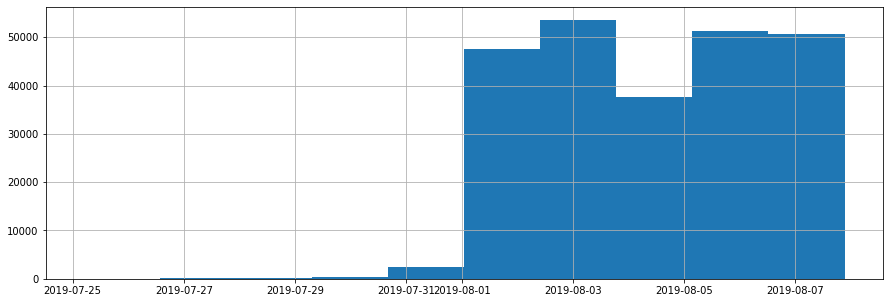

In [18]:
# menampilkan histogram berdasarkan tanggal
df['event_new_ts'].hist(figsize=(15,5))

In [19]:
# memfilter data yang dianggap data lama
df_old = df[df['event_new_ts'] < '2019-08-01']
# menampilkan data lama
df_old

,event,user_id,event_ts,exp_number,event_new_ts,event_date
0,Main Screen Appear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,Main Screen Appear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,Payment Screen Successful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,Cart Screen Appear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,Payment Screen Successful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
2823,Offers Screen Appear,2413191300976302222,1564617295,247,2019-07-31 23:54:55,2019-07-31
2824,Main Screen Appear,5505110279185484837,1564617450,247,2019-07-31 23:57:30,2019-07-31
2825,Main Screen Appear,5505110279185484837,1564617462,247,2019-07-31 23:57:42,2019-07-31
2826,Main Screen Appear,5505110279185484837,1564617472,247,2019-07-31 23:57:52,2019-07-31


In [20]:
# memfilter data baru
df_new = df[df['event_new_ts'] >= '2019-08-01']
# menampilkan data baru
df_new

,event,user_id,event_ts,exp_number,event_new_ts,event_date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,Main Screen Appear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,Main Screen Appear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,Offers Screen Appear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,Main Screen Appear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
244121,Main Screen Appear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,Main Screen Appear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,Main Screen Appear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,Main Screen Appear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


Sekarang kita memiliki data yang berjumlah 240887 baris, kita telah mengeliminasi data lama sejumlah 2826 baris. Jumla yang terbilang sedikit.

Setelah kita selesai memfilter data, kita juga perlu memastikan bahwa ada pengguna pada setiap kelompok.

In [21]:
# memastikan ada pengguna pada ketiga grup event
df_new['exp_number'].value_counts()

248    84563
246    79302
247    77022
Name: exp_number, dtype: int64

## Tahap 3. Mempelajari Event Funnel
Kita telah selesai menganalisa data. Di tahap ketiga ini, kita akan mempelajari corong peristiwa / event funnel yang kita miliki. Pertama, mari kita lihat event dan berapa frekuensi kemunculannya.

In [22]:
# melihat event dan frekuensi kemunculannya
event_log = df_new.pivot_table(index='event',values='event_new_ts', aggfunc='count').sort_values(by='event_new_ts', 
                                                                                                      ascending=False)
event_log

,event_new_ts
event,
Main Screen Appear,117328
Offers Screen Appear,46333
Cart Screen Appear,42303
Payment Screen Successful,33918
Tutorial,1005


In [23]:
# melihat jumlah pengguna yang melakukan setiap tindakan event
user_event = df_new.groupby('event').agg({'user_id':'nunique'})
user_event.sort_values(by='user_id',ascending=False)

,user_id
event,
Main Screen Appear,7419
Offers Screen Appear,4593
Cart Screen Appear,3734
Payment Screen Successful,3539
Tutorial,840


In [24]:
# menghitung proporsi pengguna yang melakukan tindakan minimal 1x
user_prop = user_event.apply(lambda x: x*100/x.sum())
user_prop.sort_values(by='user_id',ascending=False)

,user_id
event,
Main Screen Appear,36.864596
Offers Screen Appear,22.822360
Cart Screen Appear,18.554037
Payment Screen Successful,17.585093
Tutorial,4.173913


Menurut saya, urutan ini terjadi begitu pengguna membuka aplikasi, halaman pertama yang muncul tentu saja halaman utama/main screen. Promo atau diskon umumnya muncul sebagai pop-up pada aplikasi. Setelah melihat promo yang ditawarkan, ada 2 pilihan yang dilakukan pengguna yaitu memasukkan item promo ke keranjang/cart, atau melewatkan promo karena tidak berminat dengan item yang ditawarkan.

Setelah pengguna merasa sudah cukup berbelanja, mereka akan beralih ke halaman berikutnya untuk melakukan pembayaran. Untuk halaman tutorial yang biasanya muncul setelah halaman utama, banyak pengguna yang memilih untuk melewati halaman ini, maka jumlah pengguna yang melakukan tutorial jauh lebih sedikit dibandingkan jumlah pengguna pada halaman lainnya.

### Membuat Pivot Table
Untuk membuat event funnel, kita akan membuat pivot table lebih dulu dengan menggunakan pengguna sebagai indeks, event sebagai kolom dan waktu serta tanggal sebagai values untuk mengetahui tahapan yang dilakukan pengguna.

In [25]:
# membuat pivot table pengguna yang terus berlanjut dari halaman pertama hingga akhir
event_funnel = df_new.pivot_table(index='user_id',
                                 columns='event',
                                 values='event_new_ts',
                                 aggfunc='min')
event_funnel

event,Cart Screen Appear,Main Screen Appear,Offers Screen Appear,Payment Screen Successful,Tutorial
user_id,,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58,NaT
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40,NaT
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45,NaT
...,...,...,...,...,...
9217594193087726423,2019-08-02 09:00:58,NaT,2019-08-02 09:01:08,2019-08-02 09:00:57,NaT
9219463515465815368,2019-08-06 16:49:40,2019-08-05 05:26:26,2019-08-06 16:48:57,2019-08-06 16:52:16,NaT
9220879493065341500,2019-08-02 17:59:16,2019-08-02 17:58:48,2019-08-02 17:59:00,NaT,NaT


In [26]:
# membuat corong
step_1 = ~event_funnel['Main Screen Appear'].isna()
step_2 = step_1 & (event_funnel['Offers Screen Appear'] > event_funnel['Main Screen Appear'])
step_3 = step_2 & (event_funnel['Cart Screen Appear'] > event_funnel['Offers Screen Appear'])
step_4 = step_3 & (event_funnel['Payment Screen Successful'] > event_funnel['Cart Screen Appear'])

Karena jumlah event tutorial sangat sedikit, kita akan menganggapnya sebagai outlier dan tidak mengikutsertakannya dalam pembuatan funnel.

In [27]:
# mengaplikasikan corong
n_main_screen = event_funnel[step_1].shape[0]
n_offer_screen = event_funnel[step_2].shape[0]
n_cart_screen = event_funnel[step_3].shape[0]
n_payment_screen = event_funnel[step_4].shape[0]

In [28]:
# mencetak hasil corong
print('Main screen:', n_main_screen)
print('Offer screen:', n_offer_screen)
print('Cart screen:', n_cart_screen)
print('Payment screen:', n_payment_screen)

Main screen: 7419
Offer screen: 4201
Cart screen: 1767
Payment screen: 454


Pada main screen, kita memiliki 7419 pengguna dan pada event offer screen, jumlah pengguna kita berkurang hampir separuhnya. Mungkin pengguna hanya ingin melihat-lihat aplikasi saja, atau tidak sengaja membuka aplikasi. Jumlah pengguna yang sampai pada tahap pembayaran berjumlah 454 orang.

### Rasio Pengguna dari Tahap ke Tahap
Berikutnya kita akan menghitung rasio pengguna tahap ke tahap mulai dari main screen hingga tahap payment.

In [29]:
# menghitung rasio pengguna tahap ke tahap
print('Percentage user between offer screen and main screen:', round((n_offer_screen/n_main_screen*100),3),'%')
print('Percentage user between cart screen and offer screen:', round((n_cart_screen/n_offer_screen*100),3),'%')
print('Percentage user between payment screen and cart screen:',round((n_payment_screen/n_cart_screen*100),3),'%')

Percentage user between offer screen and main screen: 56.625 %
Percentage user between cart screen and offer screen: 42.061 %
Percentage user between payment screen and cart screen: 25.693 %


In [30]:
# menghitung persentase pengguna yang berhasil melakukan tindakan dari tahap awal hingga akhir
print('Percentage of user who start event from beginning to end:', round((n_payment_screen/n_main_screen*100),3),'%')

Percentage of user who start event from beginning to end: 6.119 %


Pengguna yang melakukan tahap awal yaitu main screen hingga ke tahap akhir yaitu payment, hanya berjumlah 6%.

## Tahap 4. Mempelajari Hasil Eksperimen
Pada tahap ini, kita akan mempelajari hasil eksperimen untuk mengetahui lebih lanjut mengenai aktivitas pengguna dan juga melakukan uji statistik.

### Menghitung Jumlah Pengguna Setiap Kelompok

In [31]:
# menghitung jumlah pengguna di setiap kelompok
users_group = df_new.pivot_table(index='exp_number',
                                 values='user_id',
                                 aggfunc='nunique')
users_group

,user_id
exp_number,
246,2484
247,2513
248,2537


Jumlah pengguna pada masing-masing kelompok tidak memiliki perbedaan yang siginifikan. Jumlahnya hanya selisih beberapa puluh orang saja.

### Event Paling Populer di Setiap Kelompok

In [32]:
# melihat event paling populer pada setiap kelompok
users_event_per_group = df_new.pivot_table(index='event',
                                          values='user_id',
                                          columns='exp_number',
                                          aggfunc='nunique').sort_values(by=246, ascending=False)

In [33]:
# menampilkan data
users_event_per_group

exp_number,246,247,248
event,,,
Main Screen Appear,2450,2476,2493
Offers Screen Appear,1542,1520,1531
Cart Screen Appear,1266,1238,1230
Payment Screen Successful,1200,1158,1181
Tutorial,278,283,279


In [34]:
# trials exp number 246 unique users 2484
# success main screen exp number 246 unique users 2450

In [35]:
users_group.loc[246]

user_id    2484
Name: 246, dtype: int64

In [36]:
users_event_per_group.loc['Main Screen Appear', 246]

2450

### Melakukan A/A Testing = 246/247
Uji pertama yang kita lakukan adalah A/A testing, yaitu tes kesetaraan populasi antara kelompok 246 dan 247. Kedua kelompok ini menggunakan aplikasi dengan font lama. Kita menggunakan tingkat signifikansi 0.01

In [37]:
def check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01):
    # proportion of successes in the first group:
    p1 = successes1/trials1
    
    # proportion of successes in the second group:
    p2 = successes2/trials2
    
    # proportion of successes in the combined dataset:
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    
    # difference in proportions in datasets
    difference = p1 - p2
    
    # calculate statistics in standard deviations of the standard normal distribution
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    # set standard normal distribution (mean 0, standard deviation 1)
    distr = stats.norm(0, 1)
    
    # calculate statistics in standard deviations of the standard normal distribution
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-value: ', p_value)
    if (p_value < alpha):
        print("Reject the null hypothesis: there is a significant difference between the shares")
    else:
        print("Failed to reject the null hypothesis, there is no reason to consider the shares different")

In [38]:
check_hypothesis(users_event_per_group.loc['Main Screen Appear', 246],
                 users_event_per_group.loc['Main Screen Appear', 247],
                 users_group.loc[246],
                 users_group.loc[247])

p-value:  [0.75705972]
Failed to reject the null hypothesis, there is no reason to consider the shares different


In [39]:
def check_event_hypothesis(users_events_per_group, users_group,
                           event,
                           exp1, exp2
                          ):
    frac1 = users_events_per_group.loc[event, exp1] / users_group.loc[exp1]
    frac2 = users_events_per_group.loc[event, exp2] / users_group.loc[exp2]
    print(f'{frac1} event {event} group {exp1}')
    print(f'{frac2} event {event} group {exp2}')
    check_hypothesis(users_events_per_group.loc[event, exp1],
                     users_events_per_group.loc[event, exp2],
                     users_group.loc[exp1],
                     users_group.loc[exp2],
                    )

In [40]:
for event in users_event_per_group.index:
    check_event_hypothesis(users_event_per_group, users_group,
                          event, 246, 247)
    print('---------------------------------------------------------------')

user_id    0.986312
Name: 246, dtype: float64 event Main Screen Appear group 246
user_id    0.985277
Name: 247, dtype: float64 event Main Screen Appear group 247
p-value:  [0.75705972]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.620773
Name: 246, dtype: float64 event Offers Screen Appear group 246
user_id    0.604855
Name: 247, dtype: float64 event Offers Screen Appear group 247
p-value:  [0.24809546]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.509662
Name: 246, dtype: float64 event Cart Screen Appear group 246
user_id    0.492638
Name: 247, dtype: float64 event Cart Screen Appear group 247
p-value:  [0.22883372]
Failed to reject the null hypothesis, there is no reason to consider the shares different
-------------------------------------------

**Hasil uji kelompok 246 dan 247:**
Tidak ada perbedaan signifikan diantara kedua kelompok.


### Melakukan A/B Testing = 246/248
Berikutnya kita melakukan uji statistik antara kelompok 246 dan 248. Kelompok 246 menggunakan aplikasi dengan font lama dan kelompok 248 menggunakan aplikasi dengan font baru.

In [41]:
# menguji kelompok 246 dan 248
for event in users_event_per_group.index:
    check_event_hypothesis(users_event_per_group, users_group,
                          event, 246, 248)
    print('---------------------------------------------------------------')

user_id    0.986312
Name: 246, dtype: float64 event Main Screen Appear group 246
user_id    0.982657
Name: 248, dtype: float64 event Main Screen Appear group 248
p-value:  [0.29497219]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.620773
Name: 246, dtype: float64 event Offers Screen Appear group 246
user_id    0.603469
Name: 248, dtype: float64 event Offers Screen Appear group 248
p-value:  [0.20836205]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.509662
Name: 246, dtype: float64 event Cart Screen Appear group 246
user_id    0.484825
Name: 248, dtype: float64 event Cart Screen Appear group 248
p-value:  [0.07842923]
Failed to reject the null hypothesis, there is no reason to consider the shares different
-------------------------------------------

**Hasil uji kelompok 246 dan 248:**
Tidak ada perbedaan signifikan diantara kedua kelompok.

### Melakukan A/B Testing = 247/248
Kelompok 247 menggunakan aplikasi dengan font lama dan kelompok 248 menggunakan aplikasi dengan font baru.

In [42]:
# menguji kelompok 247 dan 248
for event in users_event_per_group.index:
    check_event_hypothesis(users_event_per_group, users_group,
                          event, 247, 248)
    print('---------------------------------------------------------------')

user_id    0.985277
Name: 247, dtype: float64 event Main Screen Appear group 247
user_id    0.982657
Name: 248, dtype: float64 event Main Screen Appear group 248
p-value:  [0.45870536]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.604855
Name: 247, dtype: float64 event Offers Screen Appear group 247
user_id    0.603469
Name: 248, dtype: float64 event Offers Screen Appear group 248
p-value:  [0.91978178]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.492638
Name: 247, dtype: float64 event Cart Screen Appear group 247
user_id    0.484825
Name: 248, dtype: float64 event Cart Screen Appear group 248
p-value:  [0.57861979]
Failed to reject the null hypothesis, there is no reason to consider the shares different
-------------------------------------------

**Hasil uji kelompok 247 dan 248:**
Tidak ada perbedaan signifikan diantara kedua kelompok.


### Melakukan A/A/B Testing = 246/247/248
Uji statistik kali ini, kita akan menggabungkan data kedua kelompok kontrol (246 & 247) dan baru kemudian mengujinya dengan kelompok 248.

In [43]:
# menggabungkan data kelompok 246 dan 247
users_event_per_group_control = users_event_per_group.copy()
users_event_per_group_control.loc[:, 247] += users_event_per_group_control.loc[:, 246]
users_event_per_group_control.drop(columns=246, inplace=True)

In [44]:
# menampilkan data
users_event_per_group_control

exp_number,247,248
event,,
Main Screen Appear,4926,2493
Offers Screen Appear,3062,1531
Cart Screen Appear,2504,1230
Payment Screen Successful,2358,1181
Tutorial,561,279


In [45]:
# menggabungkan data kelompok 246 dan 247
users_group_control = users_group.copy()
users_group_control.loc[247] += users_group_control.loc[246]
users_group_control.drop(246, inplace=True)

In [46]:
# menampilkan data
users_group_control

,user_id
exp_number,
247,4997
248,2537


In [47]:
# menguji kelompok 246+247 dan 248
for event in users_event_per_group.index:
    check_event_hypothesis(users_event_per_group_control, users_group_control,
                          event, 247, 248)
    print('---------------------------------------------------------------')

user_id    0.985791
Name: 247, dtype: float64 event Main Screen Appear group 247
user_id    0.982657
Name: 248, dtype: float64 event Main Screen Appear group 248
p-value:  [0.29424527]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.612768
Name: 247, dtype: float64 event Offers Screen Appear group 247
user_id    0.603469
Name: 248, dtype: float64 event Offers Screen Appear group 248
p-value:  [0.4342555]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.501101
Name: 247, dtype: float64 event Cart Screen Appear group 247
user_id    0.484825
Name: 248, dtype: float64 event Cart Screen Appear group 248
p-value:  [0.18175875]
Failed to reject the null hypothesis, there is no reason to consider the shares different
--------------------------------------------

**Hasil uji kelompok 246, 247 dan 248:**
Tidak ada perbedaan yang signifikan antara ketiga kelompok ini.
Berarti perubahan font lam dan font baru tidak berpengaruh pada jumlah transaksi yang dilakukan pengguna.

### Menguji Dengan Alpha Berbeda
Sebelumnya, kita melakukan uji hipotesis dengan tingkat signifikansi 0.01, namun ini tingkat signifikansi ini mungkin saja memberikan hasil yang kurang tepat. Maka dari itu, kita akan mengulang uji hipotesis kita dengan menggunakan tingkat signifikansi yang berbeda, yaitu 0.05

#### Melakukan A/A Testing = 246/247
Uji pertama yang kita lakukan adalah A/A testing, yaitu tes kesetaraan populasi antara kelompok 246 dan 247. Kedua kelompok ini menggunakan aplikasi dengan font lama.

In [48]:
def check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.05):
    # proportion of successes in the first group:
    p1 = successes1/trials1
    
    # proportion of successes in the second group:
    p2 = successes2/trials2
    
    # proportion of successes in the combined dataset:
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    
    # difference in proportions in datasets
    difference = p1 - p2
    
    # calculate statistics in standard deviations of the standard normal distribution
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    # set standard normal distribution (mean 0, standard deviation 1)
    distr = stats.norm(0, 1)
    
    # calculate statistics in standard deviations of the standard normal distribution
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-value: ', p_value)
    if (p_value < alpha):
        print("Reject the null hypothesis: there is a significant difference between the shares")
    else:
        print("Failed to reject the null hypothesis, there is no reason to consider the shares different")

In [49]:
check_hypothesis(users_event_per_group.loc['Main Screen Appear', 246],
                 users_event_per_group.loc['Main Screen Appear', 247],
                 users_group.loc[246],
                 users_group.loc[247])

p-value:  [0.75705972]
Failed to reject the null hypothesis, there is no reason to consider the shares different


In [50]:
def check_event_hypothesis(users_events_per_group, users_group,
                           event,
                           exp1, exp2
                          ):
    frac1 = users_events_per_group.loc[event, exp1] / users_group.loc[exp1]
    frac2 = users_events_per_group.loc[event, exp2] / users_group.loc[exp2]
    print(f'{frac1} event {event} group {exp1}')
    print(f'{frac2} event {event} group {exp2}')
    check_hypothesis(users_events_per_group.loc[event, exp1],
                     users_events_per_group.loc[event, exp2],
                     users_group.loc[exp1],
                     users_group.loc[exp2],
                    )

In [51]:
for event in users_event_per_group.index:
    check_event_hypothesis(users_event_per_group, users_group,
                          event, 246, 247)
    print('---------------------------------------------------------------')

user_id    0.986312
Name: 246, dtype: float64 event Main Screen Appear group 246
user_id    0.985277
Name: 247, dtype: float64 event Main Screen Appear group 247
p-value:  [0.75705972]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.620773
Name: 246, dtype: float64 event Offers Screen Appear group 246
user_id    0.604855
Name: 247, dtype: float64 event Offers Screen Appear group 247
p-value:  [0.24809546]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.509662
Name: 246, dtype: float64 event Cart Screen Appear group 246
user_id    0.492638
Name: 247, dtype: float64 event Cart Screen Appear group 247
p-value:  [0.22883372]
Failed to reject the null hypothesis, there is no reason to consider the shares different
-------------------------------------------

**Hasil uji kelompok 246 dan 247:**
Tidak ada perbedaan signifikan diantara kedua kelompok.


#### Melakukan A/B Testing = 246/248
Berikutnya kita melakukan uji statistik antara kelompok 246 dan 248. Kelompok 246 menggunakan aplikasi dengan font lama dan kelompok 248 menggunakan aplikasi dengan font baru.

In [52]:
# menguji kelompok 246 dan 248
for event in users_event_per_group.index:
    check_event_hypothesis(users_event_per_group, users_group,
                          event, 246, 248)
    print('---------------------------------------------------------------')

user_id    0.986312
Name: 246, dtype: float64 event Main Screen Appear group 246
user_id    0.982657
Name: 248, dtype: float64 event Main Screen Appear group 248
p-value:  [0.29497219]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.620773
Name: 246, dtype: float64 event Offers Screen Appear group 246
user_id    0.603469
Name: 248, dtype: float64 event Offers Screen Appear group 248
p-value:  [0.20836205]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.509662
Name: 246, dtype: float64 event Cart Screen Appear group 246
user_id    0.484825
Name: 248, dtype: float64 event Cart Screen Appear group 248
p-value:  [0.07842923]
Failed to reject the null hypothesis, there is no reason to consider the shares different
-------------------------------------------

**Hasil uji kelompok 246 dan 248:**
Tidak ada perbedaan signifikan diantara kedua kelompok.

#### Melakukan A/B Testing = 247/248
Kelompok 247 menggunakan aplikasi dengan font lama dan kelompok 248 menggunakan aplikasi dengan font baru.

In [53]:
# menguji kelompok 247 dan 248
for event in users_event_per_group.index:
    check_event_hypothesis(users_event_per_group, users_group,
                          event, 247, 248)
    print('---------------------------------------------------------------')

user_id    0.985277
Name: 247, dtype: float64 event Main Screen Appear group 247
user_id    0.982657
Name: 248, dtype: float64 event Main Screen Appear group 248
p-value:  [0.45870536]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.604855
Name: 247, dtype: float64 event Offers Screen Appear group 247
user_id    0.603469
Name: 248, dtype: float64 event Offers Screen Appear group 248
p-value:  [0.91978178]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.492638
Name: 247, dtype: float64 event Cart Screen Appear group 247
user_id    0.484825
Name: 248, dtype: float64 event Cart Screen Appear group 248
p-value:  [0.57861979]
Failed to reject the null hypothesis, there is no reason to consider the shares different
-------------------------------------------

**Hasil uji kelompok 247 dan 248:**
Tidak ada perbedaan signifikan diantara kedua kelompok.


#### Melakukan A/A/B Testing = 246/247/248
Uji statistik kali ini, kita akan menggabungkan data kedua kelompok kontrol (246 & 247) dan baru kemudian mengujinya dengan kelompok 248.

In [54]:
# menguji kelompok 246+247 dan 248
for event in users_event_per_group.index:
    check_event_hypothesis(users_event_per_group_control, users_group_control,
                          event, 247, 248)
    print('---------------------------------------------------------------')

user_id    0.985791
Name: 247, dtype: float64 event Main Screen Appear group 247
user_id    0.982657
Name: 248, dtype: float64 event Main Screen Appear group 248
p-value:  [0.29424527]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.612768
Name: 247, dtype: float64 event Offers Screen Appear group 247
user_id    0.603469
Name: 248, dtype: float64 event Offers Screen Appear group 248
p-value:  [0.4342555]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.501101
Name: 247, dtype: float64 event Cart Screen Appear group 247
user_id    0.484825
Name: 248, dtype: float64 event Cart Screen Appear group 248
p-value:  [0.18175875]
Failed to reject the null hypothesis, there is no reason to consider the shares different
--------------------------------------------

**Hasil uji kelompok 246, 247 dan 248:**
Tidak ada perbedaan yang signifikan antara ketiga kelompok ini.
Berarti perubahan font lam dan font baru tidak berpengaruh pada jumlah transaksi yang dilakukan pengguna.

## Kesimpulan
Baik dengan tingkat alpha 0.01 maupun 0.05, kita memiliki hasil yang sama dari hipotesis ini:
**PERUBAHAN FONT LAMA DAN FONT BARU TIDAK BERPENGARUH PADA TRANSAKSI YANG DILAKUKAN PENGGUNA**

Ini berarti pihak web designer tidak perlu membuang waktu dan tenaga untuk membuat versi baru aplikasi dengan font baru, dan pihak manajer juga tidak perlu khawatir dengan pembaruan font yang dapat membuat pengguna kurang nyaman.